This notebook calculates coherence for each pixel for each time/interferogram and saves the files. Then, I invert a coherence-weighted velocity/disp rate for each pixel over a few different time periods.  

This notebook: <br>
1. loads in unfilt, unwrapped igrams
2. references each igram to (A) the average of the whole igram, and (B) the average phase value within a small reference region
3. Inverts for average velocity with coherence as weights, covariance matrix guided by synthetic tests I did by converting Rowena's MATLAB code.

This notebook was written on 12-12-22. Edited 2-1-23.

***

New algorithm: <br> 
load in an interferogram <br>
calculate the average phase value over the ref pixels <br>
save that <br>
load in new igram, rewrite the other one <br>
rinse and repeat. 

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

# Need this function to convert datetime objects to decimal years. Got this off of stackexchange. 
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

Do we want to run this notebook with filtered/unfiltered data? <br>
What about referenced to average phase value, reference box, or reference pixels chosen by "chooseing_reference_pixels.ipynb"

In [2]:
# choose one: 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

Grab dates of SLCs/igrams and calculate number of SLCs (nd) and igrams (numIgrams).

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
# dx = 3000
# dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

Load in the mask for reference pixels chosen with a few criteria. 

In [4]:
# load reference pixels mask 
#maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')


# filter size for calculating average reference pixels phase value for each igram.
alooks=4*4
rlooks=20*4
# filter it to use for reference pixel phase calculation.
ref_mask_filt = gaussian_filter(ref_mask,sigma = [alooks/2,rlooks/2])

Reference pixel mask loaded.


Plot mask file to be sure I'm using the right ref pix.

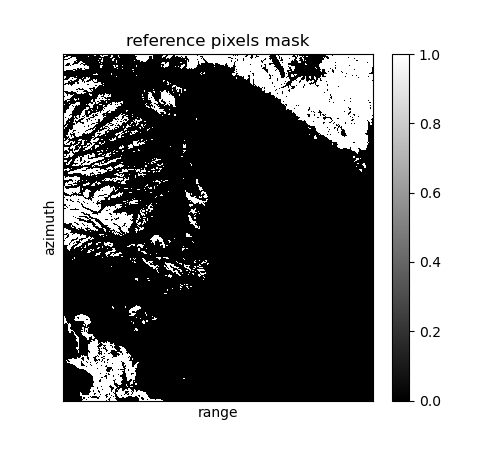

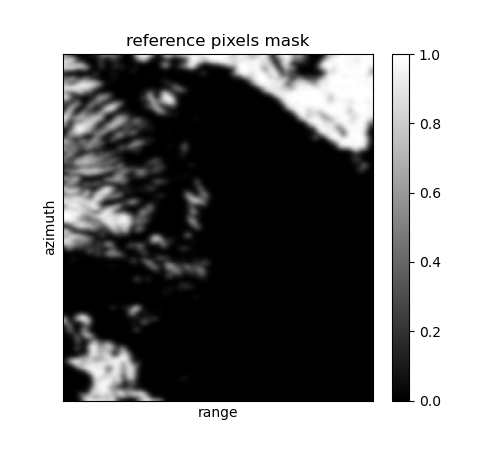

In [5]:
plt.figure(figsize=(5,4.5))
plt.imshow(ref_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(); plt.show()

plt.figure(figsize=(5,4.5))
plt.imshow(ref_mask_filt, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(); plt.show()

This stuff will change when I've calculated a ramp that I can remove. 

Read in each unfilt, unwrapped igram and calculate the average phase value over all reference pixels and save it into array. 

In [6]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
avg_ref_vals = np.ndarray((numIgrams,),dtype='float')
# ignore the divide-by-zero error messages that pop up in each loop iteration.
np.seterr(divide='ignore', invalid='ignore')

# igramsDir is where the cropped, unwrapped igrams are
#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
for i in range(numIgrams): # numIgrams if doing all of them at once
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # Now mask the igram based on ref pixels and filter it.
    igram_masked = np.zeros((dy,dx))
    igram_masked[mask_y,mask_x] = temp_igram[mask_y,mask_x]
    igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])
    ab = igram_filt / ref_mask_filt
    avg_ref_vals[i] = np.nanmean(ab) 
    print('i: '+str(i)+'\tavg_ref_val: '+str(avg_ref_vals[i]))
print('Avg value of ref pixels calculated for all '+key1+' igrams.')

# save space/RAM and clean up these variables now. 
del igramFile, ds, temp_igram

i: 0	avg_ref_val: 2.0858981121720777e+00
i: 1	avg_ref_val: 5.588769933879397e+00
i: 2	avg_ref_val: 4.1805692863214805e+00
i: 3	avg_ref_val: 3.7464966393447883e+00
i: 4	avg_ref_val: 3.6929150024338226e+00
i: 5	avg_ref_val: -5.79446209139335e+00
i: 6	avg_ref_val: 1.0413715100910728e+01
i: 7	avg_ref_val: 3.860477284712628e-01
i: 8	avg_ref_val: 4.318817114387122e+00
i: 9	avg_ref_val: -2.4945054538572306e-01
i: 10	avg_ref_val: 3.644152349392042e+00
i: 11	avg_ref_val: 6.102614899882172e+00
i: 12	avg_ref_val: 6.448979529242811e+00
i: 13	avg_ref_val: 2.263087761452878e+00
i: 14	avg_ref_val: 5.542415309589135e+00
i: 15	avg_ref_val: 3.7920207328677e+00
i: 16	avg_ref_val: 6.669198654880535e+00
i: 17	avg_ref_val: 5.521339457616815e+00
i: 18	avg_ref_val: 2.3365868173577095e-01
i: 19	avg_ref_val: 1.9203953397057067e+00
i: 20	avg_ref_val: 1.920038619354156e+00
i: 21	avg_ref_val: 6.262258042066472e-01
i: 22	avg_ref_val: 6.40059813988904e+00
i: 23	avg_ref_val: 5.843100963691766e+00
i: 24	avg_ref_val: 1

^These filtered avg phase values for ref regions checks out with other code that calculates them one-by-one (in notebook: calculate_ramps_for_ref.ipynb)

Pull out dates in order to calculate disp rates over time.

In [7]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# convert to floats 
slc_dates_floats = np.ndarray((len(slc_dates),1),dtype='float')
for i in range(len(slc_dates)):
    slc_dates_floats[i] = datetime2year(slc_dates[i]) # now an array of floats in years
# take numIgrams and pull out the igram_dates, corresponding to the second/last day of each igram
igram_dates = slc_dates[1::] # using the second SLC date per Rowena's suggestion
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt_all = np.zeros([len(dt1),1])
for i in range(len(dt_all)):
    dt_all[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)[0]))
print('igram_dates: '+str(np.shape(igram_dates)[0]))

slc_dates: 211
igram_dates: 210


Find which dates I need to separate the time series into to fit slopes for each pixel.

In [8]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(start_indices)

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]]+' - '+str(dates[end_indices[i]])))
print('\ntotal duration of this study: '+str((igram_dates[-1]-igram_dates[0]).days/365.25)+' years')

interval 0: 20170510 - 20181125
interval 1: 20181207 - 20200412
interval 2: 20200418 - 20201208
interval 3: 20201214 - 20220108
interval 4: 20170510 - 20191220
interval 5: 20170510 - 20220108
interval 6: 20200412 - 20210119

total duration of this study: 4.632443531827516 years


In [10]:
driver=gdal.GetDriverByName('ISCE')

# set up final arrays of weighted velocities and RMSE/residual stds
disp_rates_weighted = np.ndarray((num_intervals,dy,dx),dtype='float') 
disp_rates_residual_std = np.ndarray((num_intervals,dy,dx),dtype='float')

#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
# cohDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
#saveDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'

# loop through intervals 
for j in np.arange(6,7,1): #range(num_intervals), range(1) will just do the first interval 
    # pick out indices from the interval (interval j)
    interval_length = end_indices[j]-start_indices[j]
    print(str(interval_length)+' dates in interval '+str(j)+'.')

    # set up temp arrays for the row I'm extracting each time 
    temp_phs = np.ndarray((interval_length,dx),dtype='float')       # axis 0 is date/igram index, axis 1 is x coordinate
    temp_coh = np.ndarray((interval_length,dx),dtype='float')

    # loop through rows
    for y in range(dy): # range(dy)
        # load in single row of phase values, correct them (subtract avg ref value), load coherences for that row of pix
        for i in range(interval_length):
            igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_'+key1+'.unw'
            ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
            # only reading in one row at a time 
            temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1)     # (startx,starty,dx,dy)  
            # correct based on avg ref values
            temp_phs[i] = temp_phs[i] - avg_ref_vals[i]
            # load one line of coherence files
            cohFile = 'coh_'+dates[i]+'-'+dates[i+1]+'.r4'
            ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
            # only reading in one row at a time
            temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1)
    
        # loop through pixels in that row and do weighted velocity inversion.
        for x in range(dx):   # dx for all pixels 
            t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
            t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting
            noise_diags = np.ones(interval_length)*1.0                  # ones on diagonal 
            noise_off_diags = np.ones(interval_length-1)*(-0.5)         # -0.5 on off diagonals
            covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1) \
                +np.diag(noise_off_diags,1) 
            coh_at_pixel = temp_coh[:,x]                                # all dates, just the one pixel 
            variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 
            
            # sigs = np.sqrt(variances)                                   # variance same as sigma (std.dev.) squared 
            # sigs_diag = np.diag(sigs,0)                                 # diagonalize the sigmas
            
            vars_diag = np.diag(variances,0)
            covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
            icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix
            disps = temp_phs[:,x]                                       # this is disp over igrams in interval, for the single pixel  
            G_diags = np.ones((interval_length-1))
            Gint = np.diag(G_diags,1)-1*np.eye(interval_length)         # -1's along diagonal, 1's on upper off diagonal
            dt = np.diff(t.T)[0]                                        # the indices are weird from diff, the [0] index is actually the array we want.
            G_disps = dt.reshape((interval_length,1))
            Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
            model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
            vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
            wavelength = 5.5465763                                      # C-band, in cm 
            rad2cm = wavelength/(4*np.pi)                               # this is conversion factor that I multiply by the data (which is in rads)
            disp_rates_weighted[j,y,x] = rad2cm * vel_disp_rate
            model_disps = Gg_disps_weighted.dot(disps)                  # weighted inversion directly from ints 
            vel_disps = model_disps[0]
            # Cm not as useful because it heavily depends on the date/atm-related noise that we had to estimate to begin with.
            #Cm = Gg_disps_weighted.dot(covi2).dot(Gg_disps_weighted.T) # model covariance matrix
            disp_rates_weighted[j,y,x] = vel_disps
            disp_rates_residual_std[j,y,x] = np.std(disps-vel_disps)

        # print an update if we've gotten through 100*n rows
        if(np.remainder(y,100)==0):
            print('Row '+str(y)+' weighted inversions done.')

    # now save the disp rate and rmse files
    fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
    errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
    colds = driver.Create(saveDir+fileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_weighted[j])
    colds=None
    colds = driver.Create(saveDir+errorFileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_residual_std[j])
    colds=None
    print('weighted disp rates and std of residuals saved for interval '+str(j))
print('done!') 

46 dates in interval 6.
Row 0 weighted inversions done.


^
Interval 0 took ~35 min. <br>
Interval 1 took 38 min. <br>
Interval 2 took 27 min. <br>
Interval 3 took ~30 maybe? min. <br>
Interval 4 took 40 min. <br>
Interval 5 took ~2.25 hr. <br>
Interval 6 took ?? min. <br>

Plot the weighted disp rate map.

In [ ]:
i = 5 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_weighted[i], aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

Load in disp rate map if haven't just run it. 

In [ ]:
driver=gdal.GetDriverByName('ISCE')

j = 5
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'

saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_errors = np.ndarray((dy,dx),dtype='float') 

f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None

f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
disp_rates_errors = f1.ReadAsArray()
f1 = None

print('interval '+str(j)+' disp rate map + errors loaded.')

In [ ]:
i = 5 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates, aspect='auto', vmin=-2.0,vmax=2.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_errors, aspect='auto',\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()